# H&M Fashion Dataset
a notebook to explore the [H&M Fashion dataset](https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations) in order to prepare a `Dataset` class and `Dataloader` 

note that I've tried to find a link between the articles in this dataset and those from their web page (e.g. the [US store](https://www2.hm.com/en_us/index.html)) and couldnt find links yet.


In [6]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
import pandas as pd
from glob import glob as Glob
import json
import pandas as pd
%matplotlib inline

!which python

/bin/bash: /home/guy/anaconda3/envs/dis_ir/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/home/guy/anaconda3/envs/dis_ir/bin/python


In [7]:
# set the dataset_path
if os.uname()[1]=='guy-x':
    dataset_path = '/home/guy/sd1tb/datasets/h-and-m-personalized-fashion-recommendations'
else:   # assuming gpu15
    dataset_path = '/data/users/gkoren2/datasets/h-and-m-personalized-fashion-recommendation'       # gpu15

print(f"assuming we're on {os.uname()[1]} so data is in {dataset_path}")



assuming we're on guy-x so data is in /home/guy/sd1tb/datasets/h-and-m-personalized-fashion-recommendations


In [ ]:
# option 1 to handle images 
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

def image_grid2(imgs, nrows = 1, ncols=1,figsize=(16, 16)):
    """Plot a dictionary of Image objects.

    Parameters
    ----------
    figures : dict of Image objects
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows,figsize=figsize)
    for ind,aid in enumerate(imgs):
        axeslist.ravel()[ind].imshow(imgs[aid])
        axeslist.ravel()[ind].set_title(aid)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional


In [ ]:
# option 2 to handle images
import cv2
def plot_figures(figures, nrows = 1, ncols=1,figsize=(8, 8)):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows,figsize=figsize)
    for ind,title in enumerate(figures):
        axeslist.ravel()[ind].imshow(cv2.cvtColor(figures[title], cv2.COLOR_BGR2RGB))
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional
    
def img_path(img):
    return dataset_path+"/images/"+img

def load_image(img, resized_fac = 0.1):
    img     = cv2.imread(img_path(img))
    w, h, _ = img.shape
    resized = cv2.resize(img, (int(h*resized_fac), int(w*resized_fac)), interpolation = cv2.INTER_AREA)
    return resized


def load_image2(img, resize = 0.1):
    img     = cv2.imread(img_path(img))
    w, h, _ = img.shape
    if isinstance(resize,float):
        resized = cv2.resize(img, (int(h*resize), int(w*resize)), interpolation = cv2.INTER_AREA)
    elif isinstance(resize,int):
        resized = cv2.resize(img, (int(resize), int(resize)), interpolation = cv2.INTER_AREA)
    else:  # tuple (h,w)
        resized = cv2.resize(img, (int(resize[0]), int(resize[1])), interpolation = cv2.INTER_AREA)
    return resized

# Exploration
Description provided by the site:
- images/ - a folder of images corresponding to each article_id; images are placed in subfolders starting with the first three digits of the article_id; note, not all article_id values have a corresponding image.
- articles.csv - detailed metadata for each article_id available for purchase
- customers.csv - metadata for each customer_id in dataset
- sample_submission.csv - a sample submission file in the correct format
- transactions_train.csv - the training data, consisting of the purchases each customer for each date, as well as additional information. Duplicate rows correspond to multiple purchases of the same item. Your task is to predict the article_ids each customer will purchase during the 7-day period immediately after the training data period.

## Annotations

### Items

In [8]:
adf = pd.read_csv(dataset_path + "/articles.csv",on_bad_lines='skip')
# df['image'] = df.apply(lambda row: str(row['id']) + ".jpg", axis=1)
# df = df.reset_index(drop=True)
print(adf.shape)
adf.head()

(105542, 25)


,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [ ]:
np.any(['1087261006' in str(a) for a in adf['article_id'].values])

In [ ]:
query = ['Oversized Hoodie' in str(a) for a in adf['detail_desc'].values]
adf.loc[query,:]

In [9]:
adf.columns

Index(['article_id', 'product_code', 'prod_name', 'product_type_no',
       'product_type_name', 'product_group_name', 'graphical_appearance_no',
       'graphical_appearance_name', 'colour_group_code', 'colour_group_name',
       'perceived_colour_value_id', 'perceived_colour_value_name',
       'perceived_colour_master_id', 'perceived_colour_master_name',
       'department_no', 'department_name', 'index_code', 'index_name',
       'index_group_no', 'index_group_name', 'section_no', 'section_name',
       'garment_group_no', 'garment_group_name', 'detail_desc'],
      dtype='object')

In [ ]:
# measure how many unique values in each column:
{c:len(adf[c].value_counts()) for c in adf.columns}

In [ ]:
adf['product_type_name'].value_counts()
# adf['product_type_name'].hist()

In [ ]:
adf['product_group_name'].value_counts()

In [ ]:
adf['perceived_colour_master_name'].value_counts()

In [ ]:
adf['perceived_colour_value_name'].value_counts()

In [ ]:
adf['colour_group_name'].value_counts()

In [ ]:
adf['graphical_appearance_name'].value_counts()

In [ ]:
adf['department_name'].value_counts()

In [ ]:
adf['garment_group_name'].value_counts()

### users

In [ ]:
cdf = pd.read_csv(dataset_path + "/customers.csv",on_bad_lines='skip')
# df['image'] = df.apply(lambda row: str(row['id']) + ".jpg", axis=1)
# df = df.reset_index(drop=True)
print(cdf.shape)
cdf.head(10)

### Transactions

In [ ]:
trdf = pd.read_csv(dataset_path + "/transactions_train.csv",on_bad_lines='skip')
# df['image'] = df.apply(lambda row: str(row['id']) + ".jpg", axis=1)
# df = df.reset_index(drop=True)
print(trdf.shape)
trdf.head()

In [ ]:
trdf['customer_id'].value_counts()

In [ ]:
cdf=trdf.loc[trdf['customer_id']=='be1981ab818cf4ef6765b2ecaea7a2cbf14ccd6e8a7ee985513d9e8e53c6d91b',:]
cdf

In [ ]:
cdf['t_dat'].value_counts(sort=False)

in an attempt to see if there's a sense in session-inzation by date, lets have a look at all items that a customer purchased in 2 different days and see if we can cluster them:


In [ ]:
cdf.head()

In [ ]:
day1_arts=cdf.loc[cdf['t_dat']=='2020-09-10','article_id'].values
day2_arts=cdf.loc[cdf['t_dat']=='2018-09-26','article_id'].values

print(day1_arts)
print(day2_arts)

In [ ]:
get_imgs_by_aid(day1_arts)

In [ ]:
get_imgs_by_aid(day2_arts)

In [ ]:
pd.concat([adf.loc[adf['article_id']==a] for a in day1_arts])

## images

In [ ]:
img_fn=[i for i in Glob(f'{dataset_path}/images/**/*.jpg',recursive=True)]
len(img_fn)

In [ ]:
adf = pd.read_csv(dataset_path + "/articles.csv",on_bad_lines='skip')
# adf['img_fn'] = adf.apply(lambda row: dataset_path+'/images/0'+str(row['article_id'])[:2]+'/0'+str(row['article_id']) + ".jpg", axis=1)
def get_imgs_by_aid(aid_list,size=(256,256)):
    aid_df = adf.loc[adf['article_id'].isin(aid_list),:]
    ifn={str(a):f for f in img_fn for a in aid_list if str(a) in f }
    imgs = {os.path.splitext(os.path.basename(a))[0]:Image.open(ifn[a]) for a in ifn}
    [i.thumbnail(size) for i in imgs.values()]
    print(aid_df.to_markdown())
    image_grid2(imgs,1,len(imgs))


In [ ]:
aid_list=adf.loc[10:15,'article_id'].values
get_imgs_by_aid(aid_list)

In [ ]:
def create_square_img(img,size):
    
    old_size = img.size  # old_size[0] is in (width, height) format

    ratio = float(size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    # use thumbnail() or resize() method to resize the input image

    # thumbnail is a in-place operation

    # im.thumbnail(new_size, Image.ANTIALIAS)

    im = img.resize(new_size, Image.ANTIALIAS)
    # create a new image and paste the resized on it

    new_im = Image.new("RGB", (size, size))
    new_im.paste(im, ((size-new_size[0])//2,
                        (size-new_size[1])//2))
    return new_im    

In [ ]:
import cv2
def create_square_img2(img,size,border_type=cv2.BORDER_CONSTANT,border_value=(255,255,255)):
    '''
    border_type can also be cv2.BORDER_REPLICATE
    '''
    old_size = img.size  # old_size[0] is in (width, height) format
    print(f'original size: {old_size}')
    ratio = float(size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    # use thumbnail() or resize() method to resize the input image

    # thumbnail is a in-place operation

    # im.thumbnail(new_size, Image.ANTIALIAS)
    im = img.resize(new_size, Image.ANTIALIAS)
    # create a new image and paste the resized on it

    im = np.array(im)
    if border_type==cv2.BORDER_CONSTANT:
        im = cv2.copyMakeBorder(im,(size-new_size[1])//2,(size-new_size[1])//2,(size-new_size[0])//2,(size-new_size[0])//2,cv2.BORDER_CONSTANT,value=border_value)
    else:
        im = cv2.copyMakeBorder(im,(size-new_size[1])//2,(size-new_size[1])//2,(size-new_size[0])//2,(size-new_size[0])//2,border_type)

    new_im = Image.fromarray(im)
    return new_im    

In [ ]:
create_square_img2(imgs['0609319002'],224)

In [ ]:
size=224
img=imgs['0609319002']
old_size = img.size  # old_size[0] is in (width, height) format
print(f'original size: {old_size}')
ratio = float(size)/max(old_size)
new_size = tuple([int(x*ratio) for x in old_size])
im = img.resize(new_size, Image.ANTIALIAS)
im = np.array(im)

In [ ]:
tuple(im[0,0])

In [ ]:
imsz = [Image.open(im).size for im in img_fn]
pd.Series(imsz).value_counts()
# plt.imshow(img)

In [ ]:
# find image with a given size
im=[img_fn[i] for i in range(len(img_fn)) if imsz[i] == (480,640) ]
Image.open(im[0])

In [ ]:
# resize the images with a limit on each axis size, while maintaining aspect ratio
size=(256,256)
imgs = [Image.open(im) for im in img_fn[100:110]]
[i.thumbnail(size) for i in imgs]
[im.size for im in imgs]

In [ ]:
image_grid(imgs,2,5)

In [ ]:
# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df.sample(6).iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

# Preprocess dataset
The goal is to create a folder that is a duplicate of the original dataset in structure, but where the images are already preprocessed in order to save the time during training.
any deterministic operation that doesnt harm any future augmentation should be done in this stage 

In [ ]:
img_fn=[i for i in Glob(f'{dataset_path}/images/**/*.jpg',recursive=True)]
len(img_fn)

In [ ]:
# pre-process image
import cv2
def preproc_img(imgname,size=256,value=(255,255,255)):
    img=Image.open(imgname)
    img.thumbnail((size,size))
    w,h = img.size
    imga = np.array(img)
    if imga.ndim<3:
        imga = np.array(img.convert('RGB'))
    new_img = cv2.copyMakeBorder(imga,(size-h)//2,size-h-(size-h)//2,(size-w)//2,size-w-(size-w)//2,cv2.BORDER_CONSTANT,value = (255,255,255))
    new_img=Image.fromarray(new_img)    
    return new_img

In [ ]:
preproc_img(img_fn[2])

In [ ]:
# create dst folder
dst_folder = os.path.join(dataset_path,'preprocessed_images') 
print(f'creating {dst_folder}')
os.makedirs(dst_folder)

# go over all images in the dataset and preprocess using the preproc_img
for img in tqdm(img_fn):
    dst_img_fn = dataset_path+'/preprocessed_images/'+img.split('images/')[1]
    dst_img_folder = os.path.dirname(dst_img_fn)
    if not os.path.isdir(dst_img_folder):
        os.makedirs(dst_img_folder)
    dst_img = preproc_img(img)
    dst_img.save(dst_img_fn)



In [34]:
# validate dataset
imsz = [np.array(Image.open(im)).shape for im in tqdm(img_fn)]
pd.Series(imsz).value_counts()

  0%|          | 0/105100 [00:00<?, ?it/s]

(256, 256, 3)    105100
dtype: int64

In [22]:
# identify problematic pictures
for im in tqdm(img_fn):
    img=Image.open(im)
    if np.array(img).ndim<3:
        print(im)
        break


  0%|          | 0/105100 [00:00<?, ?it/s]

<PIL.JpegImagePlugin.JpegImageFile image mode=L size=256x256 at 0x7F9DFCAEA4F0>


# Dataset Class
The goal is to prepare a dataset class and dataloader that we can use to train the VAE models in PyTorchVAE.

In [2]:
import torch
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image

In [4]:
img_fn=[i for i in Glob(f'{dataset_path}/preprocessed_images/**/*.jpg',recursive=True)]
len(img_fn)

105100

## Dataset Normalization
in order to normalize the dataset, we could either use the pytorch official normalization statistics as derived from ImageNet (see [this discussion](https://stackoverflow.com/questions/58151507/why-pytorch-officially-use-mean-0-485-0-456-0-406-and-std-0-229-0-224-0-2)):  
`mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])` 

but we might want to compute the statistics by ourselves as the images in this dataset are not that natural. they all have a clean background.
for that, lets define the dataset class without the normalization and then compute its stats

In [5]:
trn_tfms = T.Compose([
#     T.ToPILImage(),
    #---------comment out data augmentation------
    # T.ColorJitter(brightness=(0.8,1.2), 
    # contrast=(0.8,1.2), 
    # saturation=(0.8,1.2), 
    # hue=0.25),
    # T.RandomAffine(5, translate=(0.01,0.1)),
    #---------------------------------------------
    T.ToTensor(),
    # T.Normalize(mean=[0.485, 0.456, 0.406], 
    #             std=[0.229, 0.224, 0.225]),
])

val_tfms = T.Compose([
#     T.ToPILImage(),
    T.ToTensor(),
    # T.Normalize(mean=[0.485, 0.456, 0.406], 
    #             std=[0.229, 0.224, 0.225]),
])



class HnMDataset(Dataset):
    """HnMDataset dataset."""

    def __init__(self, files, transform=None):
        self.files = files
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, ix):
        fpath = self.files[ix]
#         clss = fname(parent(fpath))  # todo: read the label/attributes
        img = read_image(fpath)/255.0
        # return a dummy label at this stage as it doesnt matter
        return img,1

    def choose(self):
        return self[np.random.randint(len(self))]

    # def collate_fn(self, batch):
    #     imgs, classes = list(zip(*batch))
    #     if self.transform:
    #         imgs = [self.transform(img)[None] for img in imgs]
    #     classes = [torch.tensor([id2int[clss]]) for clss in classes]
    #     imgs, classes = [torch.cat(i).to(device) for i in [imgs, classes]]
    #     return imgs, classes

    def collate_fn(self, batch):
        imgs, classes = list(zip(*batch))
        if self.transform:
            imgs = [self.transform(img)[None] for img in imgs]
        return imgs


dataset = HnMDataset(img_fn,trn_tfms)
loader = DataLoader(dataset,batch_size=10,num_workers=0,shuffle=False)

In [6]:
batch=next(iter(loader))
b,c,h,w=next(iter(loader))[0].shape
print(b,c,h,w)

10 3 256 256


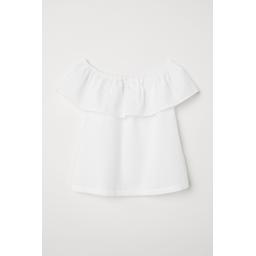

In [7]:
T.ToPILImage()(batch[0][1])


once we have the dataset defined we can compute the stats as follows ([reference](https://discuss.pytorch.org/t/computing-the-mean-and-std-of-dataset/34949))

In [7]:
# get dataset statistics. to be used for normalizing the dataset
# h,w=next(iter(loader))[0].shape[2:]
mean = 0.0
for images, _ in tqdm(loader):
    batch_samples = images.size(0) 
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
mean = mean / len(loader.dataset)

var = 0.0
for images, _ in tqdm(loader):
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    var += ((images - mean.unsqueeze(1))**2).sum([0,2])
std = torch.sqrt(var / (len(loader.dataset)*h*w))


print(f'mean:{mean},std:{std}')

  0%|          | 0/10510 [00:00<?, ?it/s]

  0%|          | 0/10510 [00:00<?, ?it/s]

mean:tensor([0.8419, 0.8286, 0.8270]),std:tensor([0.2505, 0.2614, 0.2580])


## Dataset Class definition
now that we have the dataset statistics we can create a dataset that normalizes appropriately.


In [8]:
trn_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(256),
    T.ToTensor(),
    # T.Normalize(mean=[0.8419, 0.8286, 0.8270], 
    #             std=[0.2505, 0.2614, 0.2580]),
])

val_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(256),
    T.ToTensor(),
    # T.Normalize(mean=[0.8419, 0.8286, 0.8270], 
    #             std=[0.2505, 0.2614, 0.2580]),
])

class HnMDataset(Dataset):
    """HnMDataset dataset."""

    def __init__(self, dataset_path, split='train',transform=None):
        self.files = [i for i in Glob(f'{dataset_path}/preprocessed_images/**/*.jpg',recursive=True)]
        # TODO: read item attributes:
#         anno_filename = os.path.join(dataset_path,'Anno','attributes','list_attr_items.txt')
#         with open(anno_filename,'r') as f:
#             attr_items=f.read().splitlines()
#         attr_items=attr_items[2:]
#         attr_items=[i.split() for i in attr_items]
#         self.attr_items = {i[0]:[int(int(a)>0) for a in i[1:]] for i in attr_items}
#         # get attributes names
#         anno_filename = os.path.join(dataset_path,'Anno','attributes','list_attr_cloth.txt')
#         with open(anno_filename,'r') as f:
#             attr_cloth=f.read().splitlines()
#         self.attr_names = attr_cloth[2:]

        # split the dataset and throw the irrelevant part
        train_fraction=0.8
#         train_size = int(train_fraction* len(self.attr_items.keys()))
        train_size = int(train_fraction* len(self.files))

        if split=='train':
            self.files = self.files[:train_size]
        else:
            self.files = self.files[train_size:]

        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, ix):
        fpath = self.files[ix]
#         lbl=self.attr_items[fpath.split('/')[-2]]
        lbl=1    # dummy value for now
        img = read_image(fpath)/255.0
        return img,lbl

    def choose(self):
        return self[np.random.randint(len(self))]


    def collate_fn(self, batch):
        imgs, attrs = list(zip(*batch))
        if self.transform:
            imgs = [self.transform(img)[None] for img in imgs]
        else:
            imgs = [img[None] for img in imgs]
        attrs=[torch.tensor(a)[None] for a in attrs]
        imgs,attrs = [torch.cat(i) for i in [imgs,attrs]]
        return imgs,attrs

dataset = HnMDataset(dataset_path,'train')
loader = DataLoader(dataset,batch_size=10,num_workers=0,shuffle=False,collate_fn=dataset.collate_fn)

In [9]:
dataset.files[:10]

['/home/guy/sd1tb/datasets/h-and-m-personalized-fashion-recommendations/preprocessed_images/060/0607310001.jpg',
 '/home/guy/sd1tb/datasets/h-and-m-personalized-fashion-recommendations/preprocessed_images/060/0602716004.jpg',
 '/home/guy/sd1tb/datasets/h-and-m-personalized-fashion-recommendations/preprocessed_images/060/0607691005.jpg',
 '/home/guy/sd1tb/datasets/h-and-m-personalized-fashion-recommendations/preprocessed_images/060/0609787006.jpg',
 '/home/guy/sd1tb/datasets/h-and-m-personalized-fashion-recommendations/preprocessed_images/060/0607299001.jpg',
 '/home/guy/sd1tb/datasets/h-and-m-personalized-fashion-recommendations/preprocessed_images/060/0607421011.jpg',
 '/home/guy/sd1tb/datasets/h-and-m-personalized-fashion-recommendations/preprocessed_images/060/0609760001.jpg',
 '/home/guy/sd1tb/datasets/h-and-m-personalized-fashion-recommendations/preprocessed_images/060/0600049001.jpg',
 '/home/guy/sd1tb/datasets/h-and-m-personalized-fashion-recommendations/preprocessed_images/060/

In [10]:
batch=next(iter(loader))
b,c,h,w=batch[0].shape
print(b,c,h,w)
print(batch[1].shape)

10 3 256 256
torch.Size([10])


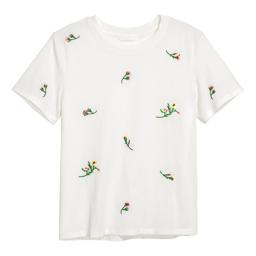

In [11]:
T.ToPILImage()(batch[0][3])

In [ ]:
batch[1][0].shape

# Draft

## CelebA
this is the dataset considered as a baseline

### explore the images

In [ ]:
clba_path = '/home/guy/sd1tb/datasets/CelebA/celeba/img_align_celeba'
# clba_path = '/data/users/gkoren2/datasets/celeba/celeba/img_align_celeba'   # gpu15
imgs_filenames=os.listdir(clba_path)
len(imgs_filenames)

In [ ]:
# extract image sizes and make sure they all at sime size
imsz = [Image.open(os.path.join(clba_path,im)).size for im in imgs_filenames]
np.all([s==imsz[0] for s in imsz])

Lets check the alignment by displaying the average of the images

In [ ]:
img_indxs = [i for i in range(1000)]
avg_img = np.zeros_like(Image.open(os.path.join(clba_path,imgs_filenames[0])),dtype=np.float64)
for i,idx in enumerate(img_indxs):
    img=Image.open(os.path.join(clba_path,imgs_filenames[idx]))
    avg_img+=np.asarray(img)
avg_img = avg_img/len(img_indxs)
Image.fromarray(np.uint8(avg_img))

ok, we see that the images are pretty much aligned. this is something that should predict the successfulness of the VAE. 

In [ ]:
# to make a gif from the images:
img_indxs = [i for i in range(1000)]
imgs = (Image.open(os.path.join(clba_path,imgs_filenames[i])) for i in img_indxs)
img = next(imgs)  # extract first image from iterator
img.save(fp='celeba.gif', format='GIF', append_images=imgs,save_all=True, duration=20, loop=0)

### load CelebA dataset class
Lets import the dataset as it is done in the VAE s.t. we understand how to prepare `DeepFashion` dataset

In [ ]:
from torchvision.datasets import CelebA
import torch.utils.data as data
from torchvision import transforms as T
# clba_path = '/data/users/gkoren2/datasets/celeba/'   # gpu15
clba_path = '/home/guy/sd1tb/datasets/CelebA/'
patch_size=256
trn_tfms = T.Compose([      # copied from dataset.py 
    T.RandomHorizontalFlip(),
    T.CenterCrop(148),
    T.Resize(patch_size),
    T.ToTensor(),
    ])

clba = CelebA(clba_path, split='train',transform=trn_tfms,download=False)

dir(clba)


In [ ]:
getattr(clba,'collate_fn',None)

In [ ]:
clba_loader = data.DataLoader(clba,batch_size=10,num_workers=0,shuffle=False)
clba_batch=next(iter(clba_loader))

In [ ]:
print(clba_batch[0].shape)       # the images tensor
print(clba_batch[1].shape)       # the labels (attributes) tensor


In [ ]:
print(len(clba.attr_names))
clba.attr_names

In [ ]:
clba_batch[0].std()

it looks like the only normalization they have applied is scaling s.t. the value of the pixels are in [0,1]. they havent normalized it to `mean=0 , stdev=1`

In [ ]:
T.ToPILImage()(clba_batch[0][1])

In [ ]:
clba_batch[1][0].shape

In [ ]:
clba_batch[1][0]